In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit

In [3]:
from convokit import Corpus
import pickle
import numpy as np
import os
from tensorly.decomposition import parafac
from convokit.tensors.utils import plot_factors
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, Counter
from jinja2 import Environment, FileSystemLoader
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [4]:
from convokit import TensorDecomposer

In [5]:
CORPUS_DIR = "convokit/tensor_decomposer/experiments/reddit-trajectory-subset-annotated"

In [6]:
import numpy as np
def _min_max_scale(mat):
    max_ = np.max(mat)
    min_ = np.min(mat)
    return (mat - min_) / (max_ - min_)

def minmax_normalize(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[2]):
        tensor[:, :, i] = _min_max_scale(tensor[:, :, i])
    return tensor

In [8]:
hyperconv_range = range(2, 20+1)
td_min_max = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(2, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_normalize,
                      rank=3
                     )

In [10]:
corpus = Corpus(CORPUS_DIR)

In [11]:
td_min_max.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


In [13]:
td_min_max.factors[1].shape

(1500, 3)

In [14]:
from sklearn.preprocessing import Imputer, Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=2020, verbose=1)

In [17]:
print(td_min_max.factors[1].shape)
projected_threads = tsne.fit_transform(td_min_max.factors[1])
print(projected_threads.shape)

(1500, 3)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.003s...
[t-SNE] Computed neighbors for 1500 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.376080
[t-SNE] KL divergence after 1000 iterations: 0.447250
(1500, 2)


In [18]:
import matplotlib.pyplot as plt

In [19]:
import random

In [20]:
for convo in corpus.iter_conversations():
    for idx, utt in enumerate(convo.get_chronological_utterance_list()):
        utt.meta['order'] = idx

In [23]:
convo_ids = [convo.id for convo in corpus.iter_conversations()]

In [25]:
for idx, convo in enumerate(corpus.iter_conversations()):
    if 0 <= idx < 500:
        convo.meta['group'] = '1.focused->expansionary'
    elif 500 <= idx < 1000:
        convo.meta['group'] = '2.expansionary->focused'
    else:
        convo.meta['group'] = '3.dyadic chain'

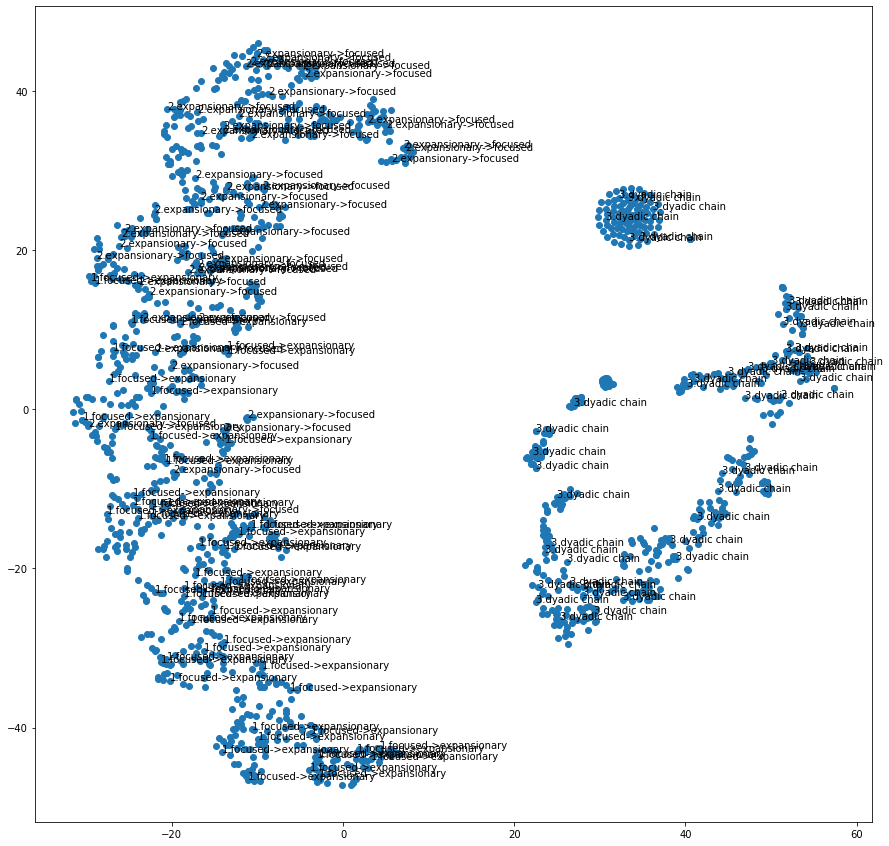

In [27]:
plt.figure(figsize=(15,15))
plt.scatter(projected_threads[:,0], projected_threads[:, 1])

for i in range(td_min_max.factors[1].shape[0]):
    if random.random() < 0.1:
        plt.annotate(corpus.get_conversation(convo_ids[i]).meta['group'], (projected_threads[i][0], projected_threads[i][1]))
    
plt.show()

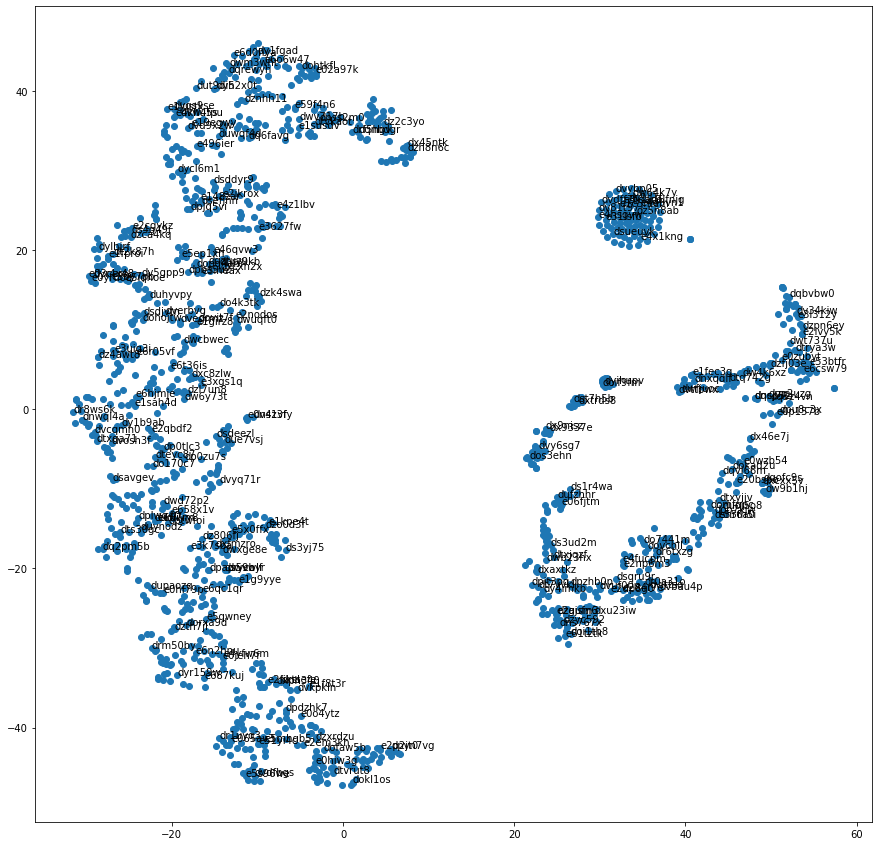

In [29]:
plt.figure(figsize=(15,15))
plt.scatter(projected_threads[:,0], projected_threads[:, 1])

for i in range(td_min_max.factors[1].shape[0]):
    if random.random() < 0.15:
        plt.annotate(convo_ids[i], (projected_threads[i][0], projected_threads[i][1]))
    
plt.show()

### tracing the reverse C curve

In [65]:
corpus.get_conversation('482-1').print_conversation_structure(lambda utt: str(utt.meta['order'] + 1) + ". " + utt.speaker.id)

1. 0x1
    2. 0x2
    3. 0x6f
        4. 0x2
    5. 0x37
        6. 0x2
            11. 0x3b
                12. 0x2
    7. 0xc2
        8. 0x2
            9. 0xc2
                10. 0x2
    13. 0x22
        14. 0x2
            15. 0x22
                16. 0x2
    17. 0xc8
        18. 0x2
            19. 0xc8
                20. 0x2


In [66]:
corpus.get_conversation('351-1').print_conversation_structure(lambda utt: str(utt.meta['order'] + 1) + ". " + utt.speaker.id)

1. 0x1
    2. 0x2
        3. 0x18
    4. 0x10
        5. 0x18
    6. 0x36
    7. 0xbc
        8. 0x36
            9. 0xbc
                10. 0x36
        11. 0x61
            12. 0x36
    13. 0x59
        14. 0x36
            15. 0x59
                16. 0x36
                    17. 0x59
                        18. 0x36
    19. 0x4b
        20. 0x36


In [67]:
corpus.get_conversation('515-1').print_conversation_structure(lambda utt: str(utt.meta['order'] + 1) + ". " + utt.speaker.id)

1. 0x1
    2. 0x2
        4. 0x17
            5. 0x35
    3. 0x35
        16. 0x47
            17. 0x44
                18. 0x47
                    19. 0x44
                        20. 0x47
    6. 0x15
    7. 0x67
        8. 0x15
            9. 0x67
                10. 0x15
                    11. 0x67
                        12. 0x15
                            13. 0x67
        15. 0x44
    14. 0x9b


In [68]:
corpus.get_conversation('354-1').print_conversation_structure(lambda utt: str(utt.meta['order'] + 1) + ". " + utt.speaker.id)

1. 0x1
    2. 0x2
    3. 0x7b
        4. 0x83
            5. 0x7b
                8. 0x2f
                    9. 0x7b
                        10. 0x2f
                            11. 0x7b
                                12. 0x2f
                                    13. 0x7b
                    15. 0x2
                        16. 0x5e
                            17. 0x2
                                18. 0x5e
                                    19. 0x2
                                        20. 0x5e
            14. 0x5e
    6. 0xc0
        7. 0x7b


In [69]:
corpus.get_conversation('525-1').print_conversation_structure(lambda utt: str(utt.meta['order'] + 1) + ". " + utt.speaker.id)

1. 0x1
    2. 0x2
        5. 0x1
            6. 0x2
    3. 0x48
        4. 0x2
    7. 0x18
        8. 0x2
            9. 0x18
                10. 0x2
                    11. 0x18
                        12. 0x2
    13. 0x12
        14. 0x2
            15. 0x12
                16. 0x2
                    17. 0x12
                        18. 0x2
    19. 0x6c
        20. 0x2


In [70]:
corpus.get_conversation('685-1').print_conversation_structure(lambda utt: str(utt.meta['order'] + 1) + ". " + utt.speaker.id)

1. 0x1
    2. 0x2
        3. 0x1
            4. 0x2
        11. 0x8
            12. 0x2
                17. 0x3
                    18. 0x6
                        19. 0x3
                            20. 0x6
        14. 0x6
            15. 0x7
                16. 0x6
    5. 0x8
        6. 0x2
            7. 0x8
                8. 0x2
                    9. 0x8
                        10. 0x2
            13. 0x7


In [71]:
corpus.get_conversation('905-1').print_conversation_structure(lambda utt: str(utt.meta['order'] + 1) + ". " + utt.speaker.id)

1. 0x1
    2. 0x2
        3. 0x1
            4. 0x2
                5. 0x1
                    6. 0x2
                        7. 0x1
                8. 0x3
                    9. 0x1
                        10. 0x3
                            11. 0x1
                                12. 0x3
                                    13. 0x1
                                        14. 0x3
                                            15. 0x1
                        16. 0x2
                            17. 0x1
                                18. 0x2
                                    19. 0x1
    20. 0x7


In [72]:
corpus.get_conversation('669-1').print_conversation_structure(lambda utt: str(utt.meta['order'] + 1) + ". " + utt.speaker.id)

1. 0x1
    2. 0x2
        3. 0x1
            4. 0x2
                5. 0x1
                    6. 0x2
                        7. 0x1
                            8. 0x2
                                9. 0x1
                                    10. 0x2
                                        11. 0x1
                                12. 0x8
                                    13. 0x1
                                        14. 0x8
                                            15. 0x1
                                                16. 0x8
                                                    17. 0x1
                            18. 0x7
                                19. 0x1
                                    20. 0x7


In [73]:
# in the ball
corpus.get_conversation('768-1').print_conversation_structure(lambda utt: str(utt.meta['order'] + 1) + ". " + utt.speaker.id)

1. 0x1
    2. 0x2
        3. 0x1
            4. 0x2
                5. 0x1
                    6. 0x2
                        7. 0x1
                            8. 0x2
                                9. 0x1
                                    10. 0x2
                                        11. 0x1
                                            12. 0x2
                                                13. 0x1
                                                    14. 0x2
                                                        15. 0x1
                                                            16. 0x2
                                                                17. 0x1
                                                                    18. 0x2
                                                                        19. 0x1
                                                                            20. 0x2


## What if we focus further specifically on the positive / negative threads only?

Since these might be most striking and therefore give us a more separated TSNE.

In [21]:
from collections import defaultdict, Counter

In [22]:
anomaly_threshold = 1.5

In [23]:
def get_anomalous_points(factor_full, idx):
    scaler = StandardScaler()
    factor = factor_full[:, idx]
    reshaped = factor.reshape((factor.shape[0], 1))
    scaled = scaler.fit_transform(reshaped)
    pos_pts = np.argwhere(scaled.reshape(factor.shape[0]) > anomaly_threshold).flatten()
    neg_pts = np.argwhere(scaled.reshape(factor.shape[0]) < -anomaly_threshold).flatten()
    return pos_pts, neg_pts

def generate_high_level_summary():
    # generate_plots()
    with open(os.path.join(DATA_DIR, 'rank_to_factors.p'), 'rb') as f:
        rank_to_factors = pickle.load(f)

    with open(os.path.join(DATA_DIR, 'hg_features.p'), 'rb') as f:
        liwc_features = pickle.load(f)

    with open(os.path.join(DATA_DIR, 'subreddits.p'), 'rb') as f:
        subreddits = pickle.load(f)

    time_factor = rank_to_factors[max_rank][0] # (9, 9)
    thread_factor = rank_to_factors[max_rank][1] # (10000, 9)
    feature_factor = rank_to_factors[max_rank][2] # (140, 9)
    idx_to_distinctive_threads = defaultdict(dict)
    idx_to_distinctive_features = defaultdict(dict)

    # normalizing
    subreddit_totals = Counter(subreddits)
    for idx in range(max_rank):
        pos_thread_pts, neg_thread_pts = get_anomalous_points(thread_factor, idx)
        idx_to_distinctive_threads[idx]['pos_threads'] = pos_thread_pts
        idx_to_distinctive_threads[idx]['neg_threads'] = neg_thread_pts

        pos_features, neg_features = get_anomalous_points(feature_factor, idx)
        idx_to_distinctive_features[idx]['pos_features'] = pos_features
        idx_to_distinctive_features[idx]['neg_features'] = neg_features

    return idx_to_distinctive_threads, idx_to_distinctive_features 

In [24]:
idx_to_distinctive_threads, idx_to_distinctive_features = generate_high_level_summary()

In [25]:
for factor_idx, threads in idx_to_distinctive_threads.items():
    print("Factor {}".format(factor_idx+1))
    print("Number of pos threads: {}".format(len(threads['pos_threads'])))
    print("Number of neg threads: {}".format(len(threads['neg_threads'])))
    print("Positive feats: {}".format(idx_to_distinctive_features[factor_idx]['pos_features']))
    print("Negative feats: {}".format(idx_to_distinctive_features[factor_idx]['neg_features']))
    print()

Factor 1
Number of pos threads: 0
Number of neg threads: 118
Positive feats: [67]
Negative feats: []

Factor 2
Number of pos threads: 105
Number of neg threads: 0
Positive feats: [  4  12  18  21  24  26  61  82  88  94  96 131]
Negative feats: [67]

Factor 3
Number of pos threads: 126
Number of neg threads: 37
Positive feats: [ 61  94 131]
Negative feats: [ 0 13 14 20 37 63 67 69]



In [26]:
included_threads = set()

for factor_idx, threads in idx_to_distinctive_threads.items():
    included_threads = included_threads.union(set(threads['pos_threads'])).union(threads['neg_threads'])

In [27]:
len(included_threads)

293

In [28]:
included_threads = sorted(included_threads)

In [29]:
factors[1][included_threads].shape

(293, 3)

In [30]:
projected_threads = tsne.fit_transform(factors[1][included_threads])
print(projected_threads.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 293 samples in 0.000s...
[t-SNE] Computed neighbors for 293 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 293 / 293
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.532124
[t-SNE] KL divergence after 1000 iterations: 0.218128
(293, 2)


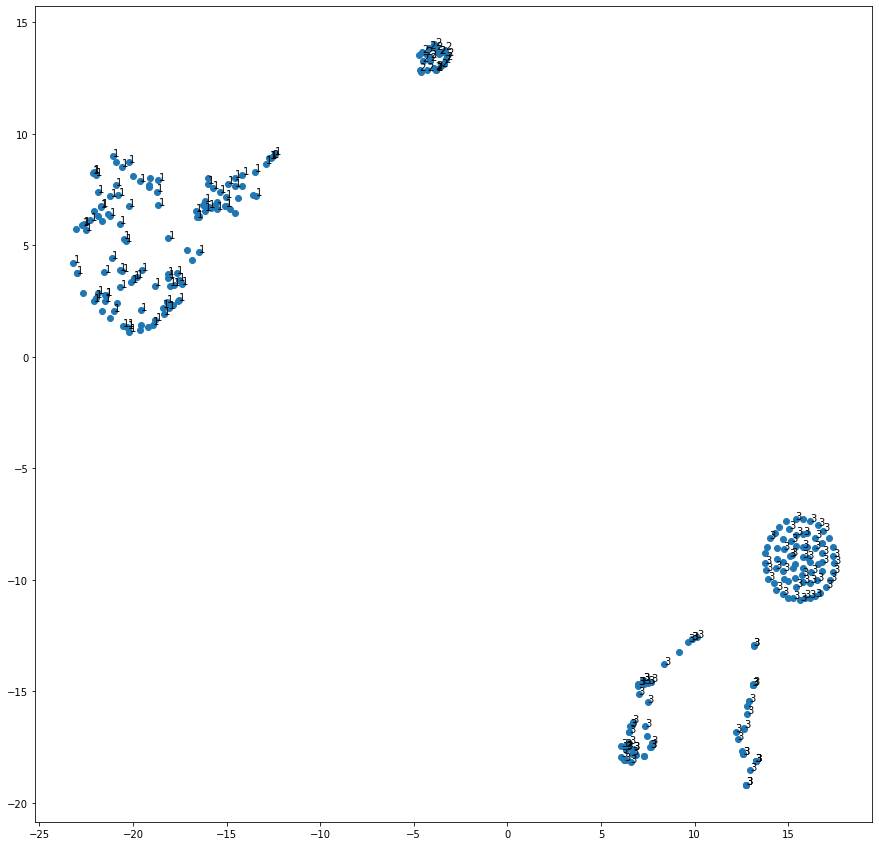

In [31]:
plt.figure(figsize=(15,15))
plt.scatter(projected_threads[:,0], projected_threads[:, 1])

for i in range(len(included_threads)):
    if random.random() < 0.7:
        plt.annotate(corpus.get_utterance(convo_ids[included_threads[i]]).meta['subreddit'][0], (projected_threads[i][0], projected_threads[i][1]))
    
plt.show()

## What if we did it with static hyperconvo features?

In [32]:
import pandas as pd

In [33]:
hc = convokit.HyperConvo(prefix_len=20)

In [34]:
hc.transform(corpus)

In [35]:
threads_feats = dict()

for convo in corpus.iter_conversations():
    threads_feats[convo.id] = convo.meta['hyperconvo']
    
def clean_value(x):
    if np.isinf(x) or np.isnan(x):
        return -1
    return x

In [36]:
feat_names = list(next(iter(threads_feats.values())).keys())

In [37]:
thread_ids = []
feats = []
for key, feat_dict in threads_feats.items():
    thread_ids.append(key)
    feats.append([clean_value(feat_dict[k]) for k in feat_names])

In [38]:
feat_df = pd.DataFrame(data=feats, index=thread_ids, columns=feat_names)

In [39]:
from sklearn.impute import SimpleImputer

In [40]:
feat_mtx = SimpleImputer(missing_values=-1).fit_transform(feat_df.values)
feat_mtx = StandardScaler().fit_transform(feat_mtx)

In [41]:
svd = TruncatedSVD(n_components=3, algorithm='arpack') # deals with an issue where the randomized alg hangs
svd.fit(feat_mtx)
U, s, V = svd.transform(feat_mtx) / svd.singular_values_, \
        svd.singular_values_, \
        svd.components_.T

In [42]:
U_norm = Normalizer().fit_transform(U)
V_norm = Normalizer().fit_transform(V)
U_df = pd.DataFrame(data=U_norm, index=feat_df.index)
V_df = pd.DataFrame(data=V_norm, index=feat_names)

In [43]:
tsne_hc = TSNE(random_state=2018)
tsne_hc_df = pd.DataFrame(data=tsne_hc.fit_transform(feat_df.values),
                      index=feat_df.index)

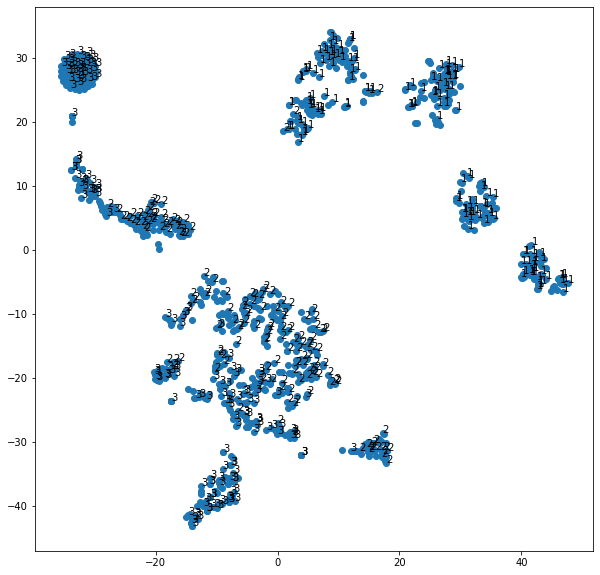

In [45]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_hc_df[0].values, tsne_hc_df[1].values)
for i, txt in enumerate(tsne_hc_df.index):
    if random.random() < 0.5:
        plt.annotate(corpus.get_utterance(txt).meta['subreddit'][0], (tsne_hc_df.values[i,0], tsne_hc_df.values[i,1]))
plt.show()